In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from copy import copy

In [2]:
from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters
phi_0 = hbar/2./e
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import matplotlib as mpl

In [3]:
from qutip import *
qutip.settings.has_mkl=False

In [4]:
def spectroscopy_bs(wd_list, A, B, eps, chi ):
    """
    Model.
    
    Input (changable)
    -----
    wd_list : numpy.ndarray (fixed variable)
        Frequency range [Hz]
    g : float (variable to be fitted)
        Coupling
    eps : float (variable to be fitted)
        probe power [Hz]
    gamma : float (variable to be fitted)
        Qubit linewidth
    A : float (variable to be fitted)
        Scalar multiplication
    B : float (variable to be fitted)
        Noise floor, scalar addition
    Returns
    -------
    spectrum : numpy.ndarray
        Spectrum
    """
    
    # Fixed variables
    
    # Cavity (b)
    wc = 4.0755e9
    kappa = 10.2e6
    Nh_spec = 5
#     
    # Qubit (a)
    detun = -300000     ## -300 kHz mismatch between the driving field and the sideband resonance condition.
    wq = wc + detun     ## Sitting on a rotating frame of the driving field.
    Aq = 150e6
    gamma = 100e3       ##homogenous linewidth
    gamma_phi = 0e3     ##inhomogenous linewidth
    Nl_spec = 4
    g = 600e3
    
    g = 2*pi*g
    chi = 2*pi*chi      ## Cross anharmonicity
    wq  = 2*pi*wq
    wc  = 2*pi*wc
    gamma = 2*pi*gamma
    gamma_phi = 2*pi*gamma_phi
    Aq = 2*pi*Aq
    kappa = 2*pi*kappa
    wd_list = wd_list*2*pi
    eps = 2*pi*eps      ## Half of the prove amplitude.
    
    # Hamiltonian
    a = tensor(destroy(Nl_spec), qeye(Nh_spec))
    b = tensor(qeye(Nl_spec), destroy(Nh_spec))
    num_b = b.dag()*b
    num_a = a.dag()*a
    r=[]
    H0 = wq*num_a + wc*num_b - 0.5*Aq*a.dag()*a.dag()*a*a - g*(a.dag()*b + b.dag()*a)
    #    qubit      cavity     anharmonicity                coupling
    
    # Calculate spectrum
    for wd in wd_list:
        H = H0 - wd*num_a - wd*num_b + eps*1j*(b.dag()-b) - 2*chi*num_a*num_b
        #        drive      drive      drive                Cross anharmonicity (chi correspondes to A_{tr} in the manuscript)
        c_ops = [np.sqrt(gamma)*a, np.sqrt(gamma_phi)*num_a, np.sqrt(kappa)*b]  
        rho_ss = steadystate(H, c_ops)  ## steady-state since interested in f-domain
        r.append([np.absolute(expect(b,rho_ss))**2/(eps**2)])
    
    out = A*np.array(r) + B
    return np.concatenate(out)

#### Combined plots

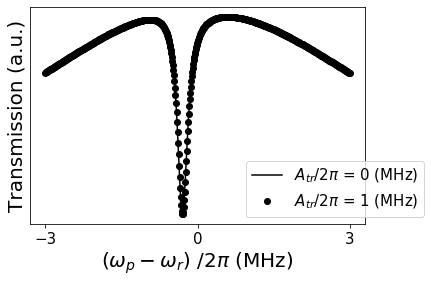

In [7]:
## Figure part (a).
A = 1
B = 0
eps = 10e3
wc = 4.0755e9
chi1 = 0e3
chi2 = 1000e3

w_points = 600
wd_list = np.linspace(wc-3e6,wc+3e6,w_points)#Hz
initguess_low1 = spectroscopy_bs(wd_list, A, B, eps, chi1)
initguess_low2 = spectroscopy_bs(wd_list, A, B, eps, chi2)

plt.figure()
plt.plot((wd_list-wc)*1e-6, initguess_low1,'k-', label=r'$A_{tr}/2\pi$ = 0 (MHz)')
plt.plot((wd_list-wc)*1e-6, initguess_low2,'ko', label=r'$A_{tr}/2\pi$ = 1 (MHz)')
plt.xlabel("$(\\omega_p-\\omega_r)$ $/2\\pi$ (MHz)",fontsize = 20)
plt.ylabel('Transmission (a.u.)',fontsize=20) 
plt.legend(loc='lower right',bbox_to_anchor=(1.2,0),fontsize=15)
plt.xticks([-3,0,3],fontsize=15)
plt.yticks([])
plt.show()
plt.close()

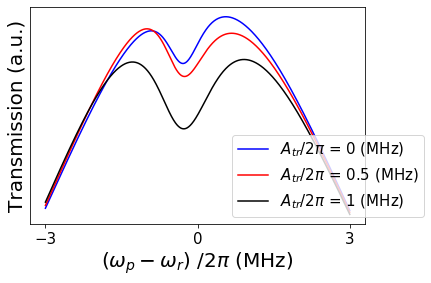

In [6]:
## Figure part (b).
A = 1
B = 0
eps = 3000e3
wc = 4.0755e9
chi1 = 0e3
chi2 = 500e3
chi3 = 1000e3


w_points = 600
wd_list = np.linspace(wc-3e6,wc+3e6,w_points)#Hz
initguess_high1 = spectroscopy_bs(wd_list, A, B, eps, chi1)
initguess_high2 = spectroscopy_bs(wd_list, A, B, eps, chi2)
initguess_high3 = spectroscopy_bs(wd_list, A, B, eps, chi3)

plt.figure()
plt.plot((wd_list-wc)*1e-6, initguess_high1,'b-', label=r'$A_{tr}/2\pi$ = 0 (MHz)')
plt.plot((wd_list-wc)*1e-6, initguess_high2,'r-', label=r'$A_{tr}/2\pi$ = 0.5 (MHz)')
plt.plot((wd_list-wc)*1e-6, initguess_high3,'k-', label=r'$A_{tr}/2\pi$ = 1 (MHz)')
plt.xlabel("$(\\omega_p-\\omega_r)$ $/2\\pi$ (MHz)",fontsize = 20)
plt.ylabel('Transmission (a.u.)',fontsize=20) 
plt.legend(loc='lower right',bbox_to_anchor=(1.2,0),fontsize=15)
plt.xticks([-3,0,3],fontsize=15)
plt.yticks([])
plt.show()
plt.close()